adapted from <https://developmentalsystems.org/sensorimotor-lenia/>


In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

from colorclade import draw_colorclade_tree
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm

from pylib._build_hstrat_surfaces import build_hstrat_surfaces
from pylib._build_path import build_path
from pylib._make_seed_coordinates import make_seed_coordinates
from pylib._pathsplot import pathsplot
from pylib.auxlib._hstrat_reconstruct_dataframe import (
    hstrat_reconstruct_dataframe,
)
from pylib.auxlib._log_context_duration import log_context_duration
from pylib.auxlib._make_hstrat_surface_dataframe import (
    make_hstrat_surface_dataframe,
)
from pylib.auxlib._make_reproducible import make_reproducible
from pylib.auxlib._transform_box_max import TransformBoxMax
from pylib.difflenia._AttributeBoxMax import AttributeBoxMax
from pylib.difflenia._VideoWriter import VideoWriter
from pylib.difflenia._generate_observations import generate_observations

torch.set_default_tensor_type("torch.FloatTensor")
make_reproducible()


/usr/local/lib/python3.10/dist-packages/alifedata_phyloinformatics_convert/_impl/phytrack_Systematcs.py:7: UserWarning: ImportWarning: phylotrackpy.Systematics import failed; inserting a no-op mock for Systematics. This is likely because phylotrackpy is not installed.
  warnings.warn(


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-03-24T23:47:22.586178+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1021-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

torch     : 2.0.1
matplotlib: 3.9.2

Watermark: 2.4.3



In [4]:
# 3 examples of discovered creatures (1 channel and 10 rules)

!wget  'https://osf.io/tqxhu/download' -O '/tmp/crea1.pickle'
!wget  'https://osf.io/tqfwk/download' -O '/tmp/crea2.pickle'
!wget  'https://osf.io/ba536/download' -O '/tmp/crea3.pickle'


--2025-03-24 23:47:22--  https://osf.io/tqxhu/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1 [following]
--2025-03-24 23:47:22--  https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12214 (12K) [application/octet-stream]
Saving to: ‘/tmp/crea1.pickle’

/tmp/crea1.pickle   100%[===================>]  11.93K  --.-KB/s    in 0s      

2025-03-24 23:47:27 (107 MB/s) - ‘/tmp/crea1.pickle’ saved [12214/12214]

--2025-03-24 23:47:27--  https://osf.io/tqfwk/download
Resolving osf.io (osf.io)... 35.190.

In [5]:
image_counter = it.count()
image_subdir = "dev-difflenia-TransformBoxMax"
os.makedirs(image_subdir, exist_ok=True)


def make_gif_path():
    return f"{image_subdir}/image_{next(image_counter):04d}.gif"


In [6]:
def show_sample_observations(
    SX,
    SY,
    *,
    borders,
    device,
    mode,
    num_frames,
    crea_file="crea1.pickle",
    every_nth=5,
    fps=30.0,
    logger=print,
    zoom=1,
):

    observations = generate_observations(
        SX=SX,
        SY=SY,
        borders=borders,
        crea_file=crea_file,
        device=device,
        mode=mode,
        num_frames=num_frames,
        zoom=zoom,
    )
    with log_context_duration("Creating video", logger=logger):
        with VideoWriter(make_gif_path(), fps) as vid:
            vid.add_observations(observations, every_nth=every_nth)
            vid.show()

    with log_context_duration("Creating reversed video", logger=logger):
        with VideoWriter(make_gif_path(), fps) as vid:
            vid.add_observations(
                observations, every_nth=every_nth, reorder=reversed
            )
            vid.show()

    return observations


In [7]:
def show_sample_hstrat_tree(
    obvs,
    SX,
    SY,
    *,
    dstream_algo,
    dstream_S,
    logger,
    num_frames,
    surface_transform,
):
    with log_context_duration("build_hstrat_surfaces", logger=logger):
        surfaces = build_hstrat_surfaces(
            [state[:, :, 0].numpy() for state in obvs.states],
            (SY, SX),
            dstream_algo=dstream_algo,
            dstream_S=dstream_S,
            surface_transform=surface_transform,
        )
    with log_context_duration("make_hstrat_surface_dataframe", logger=logger):
        surfaces_df = make_hstrat_surface_dataframe(
            surfaces[-1],
            num_frames + dstream_S,
            values=obvs.states[-1][:, :, 0].numpy(),
            dstream_algo=dstream_algo,
        )
    with log_context_duration("hstrat_reconstruct_dataframe", logger=logger):
        surfaces_phylo = hstrat_reconstruct_dataframe(
            surfaces_df[surfaces_df["value"] > 0.2],
        )
    surfaces_phylo["ancestor_list"] = [
        "[]" if id_ == ancestor_id else f"[{ancestor_id}]"
        for (id_, ancestor_id) in zip(
            surfaces_phylo["id"],
            surfaces_phylo["ancestor_id"],
        )
    ]
    with log_context_duration("draw_colorclade_tree", logger=logger):
        draw_colorclade_tree(
            surfaces_phylo,
            backend="biopython",
            label_tips=False,
            taxon_name_key="id",
        )
    plt.show()


In [8]:
SX, SY = 400, 400
borders = True
box_size = 7
device = torch.device(["cpu", "cuda"][torch.cuda.is_available()])
dstream_algo = "dstream.tilted_algo"
logger = print
mode = "random"
num_frames = 1000
dstream_S = 64
surface_transform = TransformBoxMax(box_size)


In [9]:
seed_coordinates = make_seed_coordinates(
    x_coords=range(SX // 8, SX, SX // 4),
    y_coords=range(SY // 8, SY, SY // 4),
)


/home/runner/work/hstrat-agentless-concept/hstrat-agentless-concept/binder/pylib/difflenia/_LeniaStepFFTC.py:126: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  self.kernels[i] = kernel_FFT


enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 15.30038332939148}
enter log_context_duration for Creating video


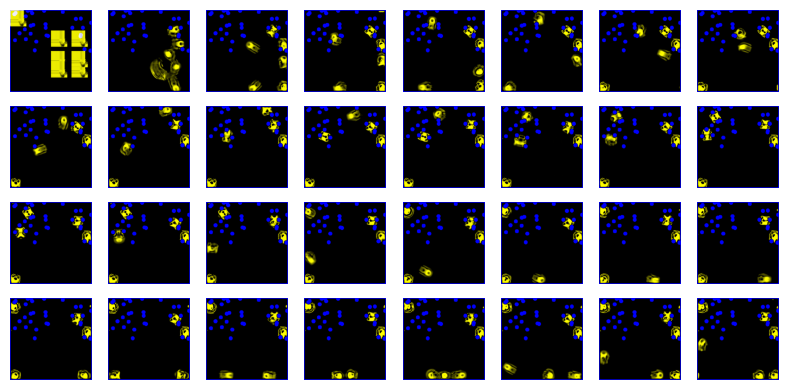

exit log_context_duration for Creating video
!!! {"Creating video": 5.252551555633545}
enter log_context_duration for Creating reversed video


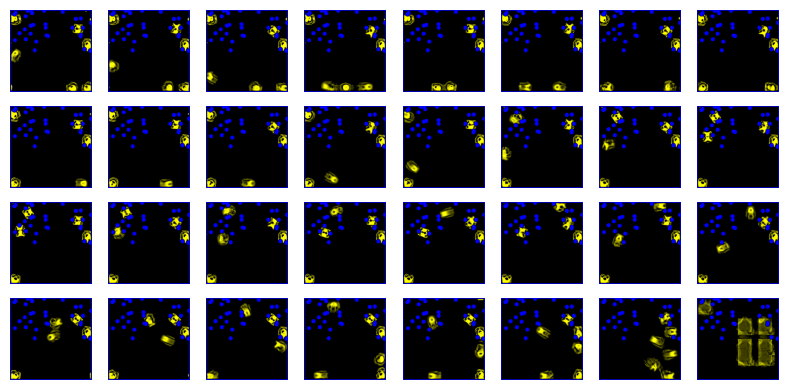

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.320993423461914}


100%|██████████| 16/16 [00:04<00:00,  3.70it/s]


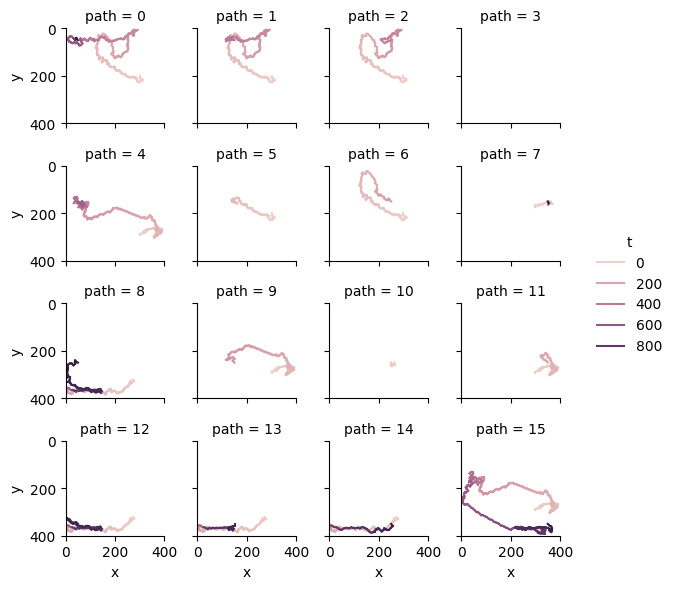

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 43.274595737457275}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.12414431571960449}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 165.4102189540863}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 18.738834857940674}


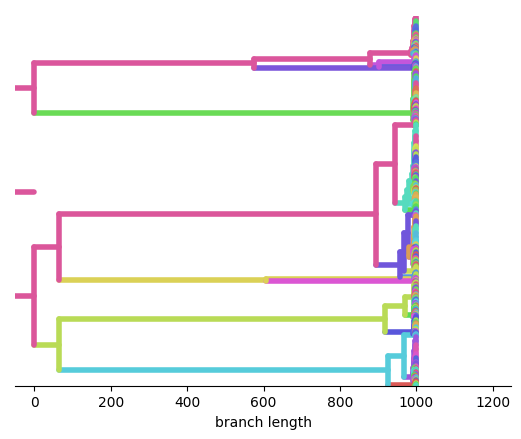

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 15.020768642425537}
enter log_context_duration for Creating video


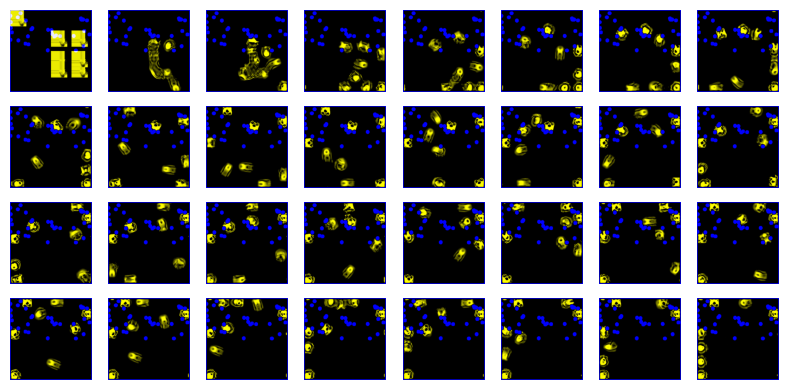

exit log_context_duration for Creating video
!!! {"Creating video": 5.389313697814941}
enter log_context_duration for Creating reversed video


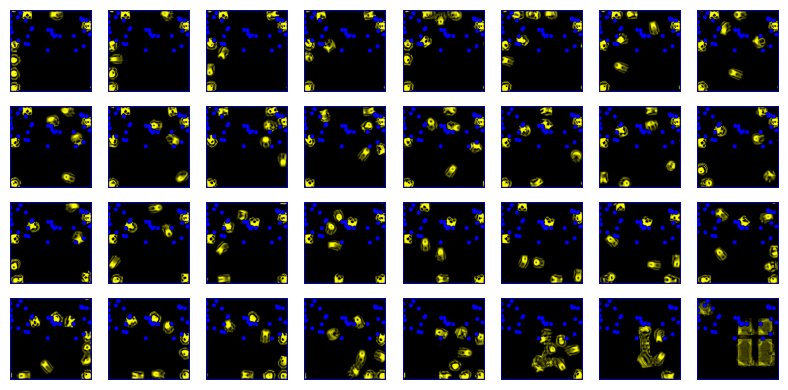

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.3685524463653564}


100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


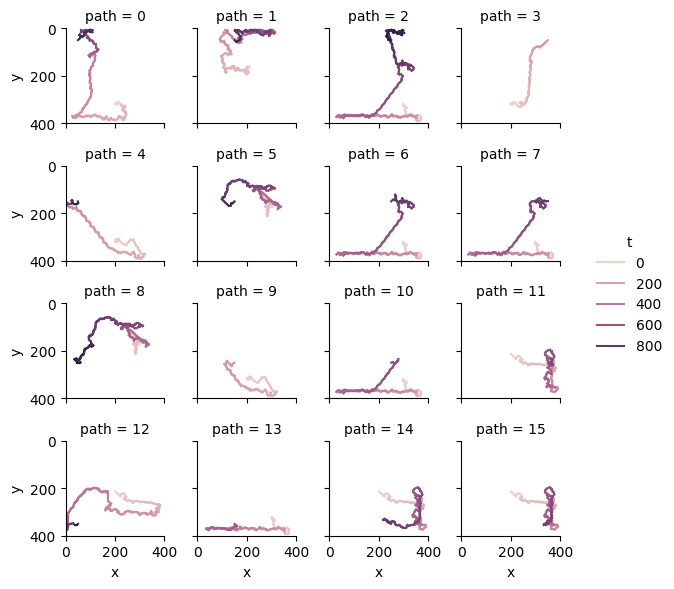

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 42.599722385406494}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.11870098114013672}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.662420749664307}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 22.63923931121826}


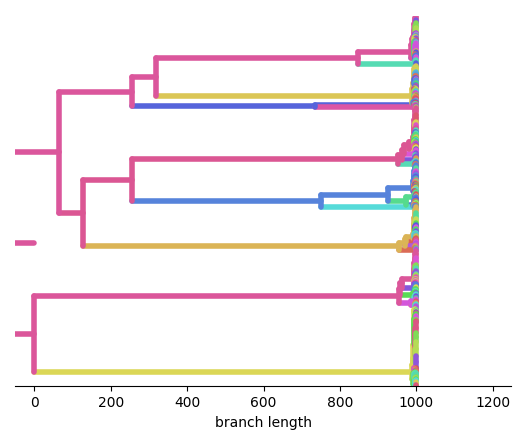

In [10]:
for i in range(2):
    obvs = show_sample_observations(
        SX,
        SY,
        borders=borders,
        crea_file="/tmp/crea1.pickle",
        device=device,
        logger=logger,
        mode=mode,
        num_frames=num_frames,
        zoom=1,
    )
    pathsplot(
        [
            build_path(
                coordinate,
                [state[:, :, 0] for state in obvs.states],
                AttributeBoxMax(box_size),
            )
            for coordinate in tqdm(seed_coordinates)
        ],
        xmax=SX,
        ymax=SY,
        col_wrap=4,
    )
    plt.show()

    show_sample_hstrat_tree(
        obvs,
        SX,
        SY,
        dstream_algo=dstream_algo,
        dstream_S=dstream_S,
        logger=logger,
        num_frames=num_frames,
        surface_transform=surface_transform,
    )


enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 15.85218858718872}
enter log_context_duration for Creating video


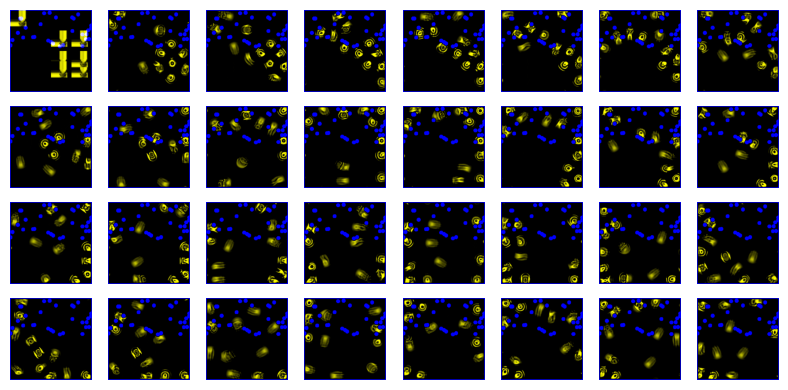

exit log_context_duration for Creating video
!!! {"Creating video": 5.381686210632324}
enter log_context_duration for Creating reversed video


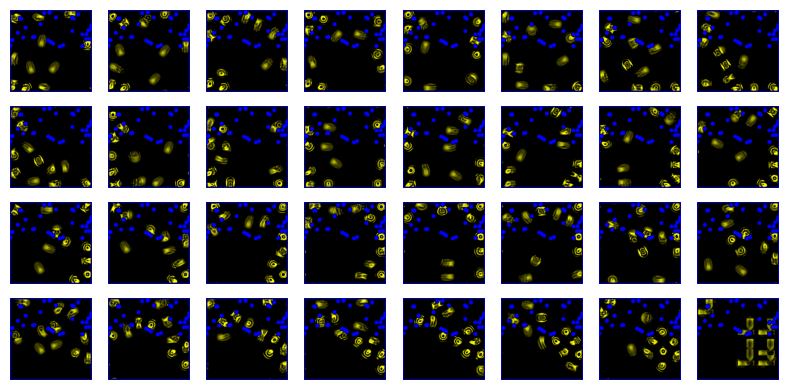

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.449746131896973}


100%|██████████| 16/16 [00:04<00:00,  3.82it/s]


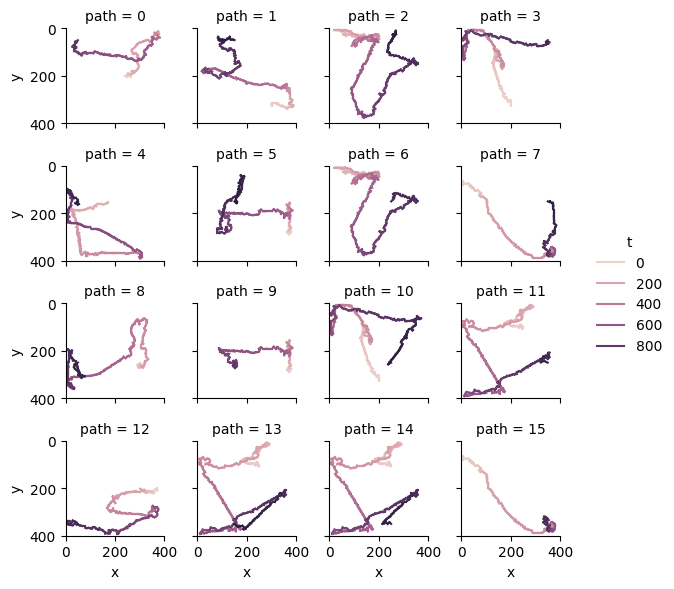

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 42.35478758811951}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.11902093887329102}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.3214054107666}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 29.213211059570312}


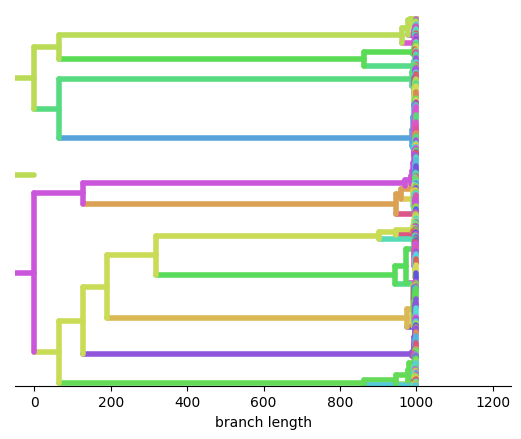

enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 14.99683165550232}
enter log_context_duration for Creating video


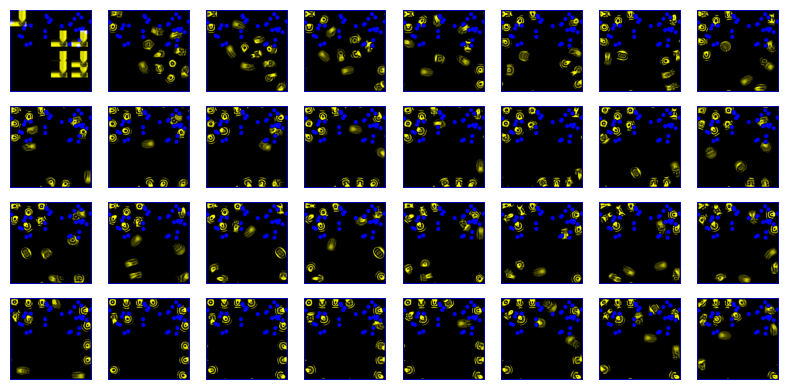

exit log_context_duration for Creating video
!!! {"Creating video": 5.5198681354522705}
enter log_context_duration for Creating reversed video


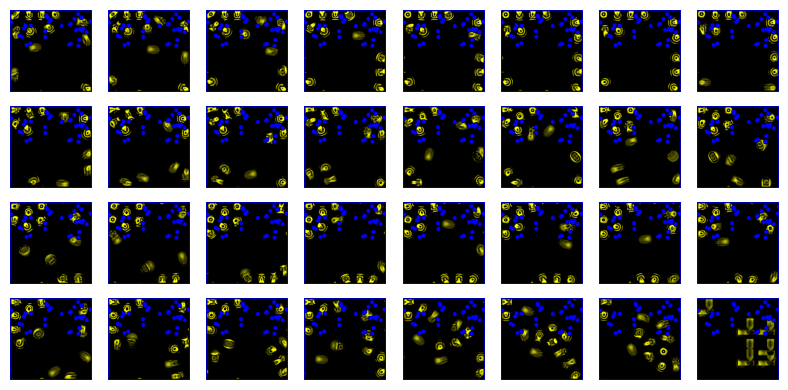

exit log_context_duration for Creating reversed video
!!! {"Creating reversed video": 5.4656431674957275}


100%|██████████| 16/16 [00:04<00:00,  3.84it/s]


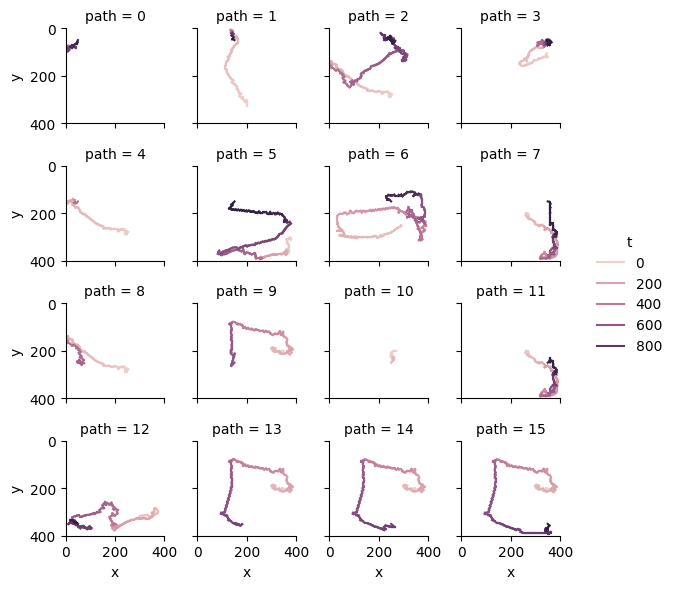

enter log_context_duration for build_hstrat_surfaces
exit log_context_duration for build_hstrat_surfaces
!!! {"build_hstrat_surfaces": 30.336180210113525}
enter log_context_duration for make_hstrat_surface_dataframe
exit log_context_duration for make_hstrat_surface_dataframe
!!! {"make_hstrat_surface_dataframe": 0.13156676292419434}
enter log_context_duration for hstrat_reconstruct_dataframe
exit log_context_duration for hstrat_reconstruct_dataframe
!!! {"hstrat_reconstruct_dataframe": 21.39752173423767}
enter log_context_duration for draw_colorclade_tree
exit log_context_duration for draw_colorclade_tree
!!! {"draw_colorclade_tree": 28.960399866104126}


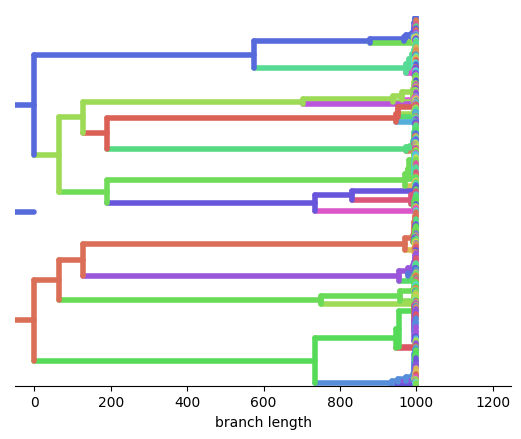

In [11]:
for i in range(2):
    obvs = show_sample_observations(
        SX,
        SY,
        borders=borders,
        crea_file="/tmp/crea2.pickle",
        device=device,
        logger=logger,
        mode=mode,
        num_frames=num_frames,
        zoom=1,
    )
    pathsplot(
        [
            build_path(
                coordinate,
                [state[:, :, 0] for state in obvs.states],
                AttributeBoxMax(box_size),
            )
            for coordinate in tqdm(seed_coordinates)
        ],
        xmax=SX,
        ymax=SY,
        col_wrap=4,
    )
    plt.show()

    show_sample_hstrat_tree(
        obvs,
        SX,
        SY,
        dstream_algo=dstream_algo,
        dstream_S=dstream_S,
        logger=logger,
        num_frames=num_frames,
        surface_transform=surface_transform,
    )
